## Non-Temporal_Classifier_V01
<br>

### Key Differences from "Devarshi_LightGBM_Classifier_Model.ipynb":

1. **Aim**: To see if there is relation between 'CAQI_level' and other columns when time is not involved.
2. v01 makes use of the 'Jupyter Notebook enviroment'.
3. Dataset used: **'train_nontemporal_classification.parquet.gz'** AND **'test_nontemporal_classification.parquet.gz'**.
4. This data **does not include** the time component.
5. For the 'CAQI_level' column, I have attempted a **merger** of 'vhigh' into the 'high' category with an intention to see an improvement in our model accuracy. 
6. The accuracy results of all the methods are mentioned in the notebook.
7. Merger technique which yielded the best result is shown in this notebook.
8. An attempt to improve accruacy using GridSearchCV was also made. 
9. The notebook has a **feature importance** section as well.
10. Also take notice of the **#commented out** codes that were used but produced ineffective results. 
---

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
%matplotlib inline

In [4]:
train = pd.read_parquet("train_nontemporal_classification.parquet.gz", engine = "pyarrow")
test = pd.read_parquet("test_nontemporal_classification.parquet.gz", engine = "pyarrow")

## 1) Train data

In [5]:
train.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,"crop production - permanent meadows, area in ha, total","crop production - permanent pastures, area in ha, total",CAQI_level,isUrban,season,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,"powiat aleksandrowski, kujawsko-pomorskie",4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie,44.997895,1.718015,...,4.884211,0.854737,vlow,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat augustowski, podlaskie",8.000000,50.0,95.0,9.0,0.0,0.4,podlaskie,47.547318,4.963793,...,16.300784,2.241712,medium,0,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat bełchatowski, łódzkie",5.923833,0.0,80.0,0.0,5.0,0.0,łódzkie,43.636364,3.809493,...,7.991736,0.686983,vlow,0,Winter,New Year's Day,0.0,0.0,1.0,1
2017-01-01,"powiat biała podlaska, lubelskie",6.000000,0.0,78.0,0.0,0.0,0.9,lubelskie,21.265306,0.138255,...,8.612245,0.551020,medium,1,Winter,New Year's Day,0.0,0.0,0.0,1
2017-01-01,"powiat białystok, podlaskie",8.000000,0.0,89.0,0.0,0.0,0.4,podlaskie,47.549020,0.305201,...,16.303922,2.245098,low,1,Winter,New Year's Day,0.0,0.0,0.0,1


In [6]:
train.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [7]:
train['CAQI_level'].describe()

count     300960
unique         5
top         vlow
freq      134555
Name: CAQI_level, dtype: object

In [8]:
train['CAQI_level'].value_counts()

vlow      134555
low       126762
medium     30737
high        8026
vhigh        880
Name: CAQI_level, dtype: int64

In [9]:
# combine high and vhigh to a single category, as we want to see how it will affect the accuracy of model
train['CAQI_level'] = train['CAQI_level'].replace({'vhigh':'high'})

In [10]:
train['CAQI_level'].value_counts()

vlow      134555
low       126762
medium     30737
high        8906
Name: CAQI_level, dtype: int64

In [11]:
# The ordered mapping of the labels to their categories 
# mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh':4}
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}
train['CAQI_level'] = train['CAQI_level'].replace(mapping)

In [12]:
train['CAQI_level'].value_counts()

0    134555
1    126762
2     30737
3      8906
Name: CAQI_level, dtype: int64

In [13]:
# encoding the other categorical columns
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    train['powiat_voivod_encoded'] = le.fit_transform(train['powiat_voivod'])
    train['voivodship_encoded'] = le.fit_transform(train['voivodship'])
    train['season_encoded'] = le.fit_transform(train['season'])
    train['holiday_name_encoded'] = le.fit_transform(train['holiday_name'])

In [14]:
train['voivodship_encoded'].head()

DATE
2017-01-01     1
2017-01-01     8
2017-01-01    13
2017-01-01     2
2017-01-01     8
Name: voivodship_encoded, dtype: int32

In [15]:
# quick check for any nulls
train.isna().sum()

powiat_voivod            0
cloud_cover              0
wind_speed               0
humidity                 0
precipitation            0
                        ..
is_weekend               0
powiat_voivod_encoded    0
voivodship_encoded       0
season_encoded           0
holiday_name_encoded     0
Length: 127, dtype: int64

In [16]:
# Remove any special characters from the column names
train.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in train.columns]

## 2) Test data

In [17]:
test.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,"crop production - permanent meadows, area in ha, total","crop production - permanent pastures, area in ha, total",CAQI_level,isUrban,season,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2021-03-02,"powiat aleksandrowski, kujawsko-pomorskie",5.000000,0.0,92.5,0.0,0.0,2.7,kujawsko-pomorskie,39.393684,1.712729,...,3.642105,0.623158,low,0,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat augustowski, podlaskie",7.000000,60.0,90.0,0.0,0.0,2.3,podlaskie,51.660036,4.947356,...,20.197709,2.318264,vlow,0,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat bełchatowski, łódzkie",4.846046,0.0,85.0,0.0,0.0,3.7,łódzkie,42.485537,3.735109,...,7.089876,0.634298,low,0,Spring,Non Holiday,0.0,0.0,1.0,0
2021-03-02,"powiat biała podlaska, lubelskie",6.000000,0.0,89.0,0.0,0.0,3.7,lubelskie,19.326531,0.136890,...,7.204082,0.285714,medium,1,Spring,Non Holiday,0.0,0.0,0.0,0
2021-03-02,"powiat białystok, podlaskie",7.000000,0.0,91.5,0.0,0.0,2.5,podlaskie,51.666667,0.304191,...,20.196078,2.313725,low,1,Spring,Non Holiday,0.0,0.0,0.0,0


In [18]:
test.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

In [19]:
test['CAQI_level'].describe()

count     60390
unique        5
top        vlow
freq      31913
Name: CAQI_level, dtype: object

In [20]:
test['CAQI_level'].value_counts()

vlow      31913
low       24346
medium     3683
high        435
vhigh        13
Name: CAQI_level, dtype: int64

In [21]:
# combine high and vhigh to a single category, as we want to see how it will affect the accuracy of model
test['CAQI_level'] = test['CAQI_level'].replace({'vhigh':'high'})

In [22]:
test['CAQI_level'].value_counts()

vlow      31913
low       24346
medium     3683
high        448
Name: CAQI_level, dtype: int64

In [23]:
# The ordered mapping of the labels to their categories 
# mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3, 'vhigh':4}
mapping = {'vlow': 0, 'low': 1, 'medium': 2, 'high': 3}
test['CAQI_level'] = test['CAQI_level'].replace(mapping)

In [24]:
test['CAQI_level'].value_counts()

0    31913
1    24346
2     3683
3      448
Name: CAQI_level, dtype: int64

In [25]:
# encoding the other categorical columns
cat_cols = ['powiat_voivod', 'voivodship', 'season', 'holiday_name']
for col in cat_cols:
    le = LabelEncoder()
    test['powiat_voivod_encoded'] = le.fit_transform(test['powiat_voivod'])
    test['voivodship_encoded'] = le.fit_transform(test['voivodship'])
    test['season_encoded'] = le.fit_transform(test['season'])
    test['holiday_name_encoded'] = le.fit_transform(test['holiday_name'])

In [26]:
train['powiat_voivod_encoded'].head()

DATE
2017-01-01    0
2017-01-01    1
2017-01-01    2
2017-01-01    3
2017-01-01    4
Name: powiat_voivod_encoded, dtype: int32

In [27]:
# quick check for any nulls
train.isna().sum()

powiat_voivod            0
cloud_cover              0
wind_speed               0
humidity                 0
precipitation            0
                        ..
is_weekend               0
powiat_voivod_encoded    0
voivodship_encoded       0
season_encoded           0
holiday_name_encoded     0
Length: 127, dtype: int64

In [28]:
# Remove any special characters from the column names
train.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in train.columns]

In [29]:
test.columns.tolist()

['powiat_voivod',
 'cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'voivodship',
 'animal stock - total',
 'area by land - utilised agricultural area',
 'area by land - forests',
 'area by land - residential areas',
 'area by land - industrial lands',
 'area by land - recreational and rest areas',
 'area by land - lands under waters',
 'area by land - wasteland',
 'area by land - other area',
 'emission of particulates - fugitive',
 'emission of particulates - fuel combustion',
 'emission of particulates - cement/lime and refractory materials',
 'emission of particulates - silicon',
 'emission of particulates - chemical fertilizers',
 'emission of particulates - surface-active agents',
 'emission of particulates - carbon and graphite, soot',
 'emission of pollutant gases - fugitive',
 'emission of pollutant gases - sulphur dioxide',
 'emission of pollutant gases - nitrogen oxides',
 'emission of pollutant gases - carbon monoxide',
 'emission

## Train and Test data are ready for use

In [30]:
# defining the features and target variable
X_train = train.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name'], axis=1)
y_train = train['CAQI_level']
X_test = test.drop(['CAQI_level','powiat_voivod', 'voivodship', 'season', 'holiday_name'], axis=1)
y_test = test['CAQI_level']

In [31]:
X_train.columns.tolist()

['cloud_cover',
 'wind_speed',
 'humidity',
 'precipitation',
 'snow_depth',
 'temperature',
 'animal_stock_total',
 'area_by_land_utilised_agricultural_area',
 'area_by_land_forests',
 'area_by_land_residential_areas',
 'area_by_land_industrial_lands',
 'area_by_land_recreational_and_rest_areas',
 'area_by_land_lands_under_waters',
 'area_by_land_wasteland',
 'area_by_land_other_area',
 'emission_of_particulates_fugitive',
 'emission_of_particulates_fuel_combustion',
 'emission_of_particulates_cement_lime_and_refractory_materials',
 'emission_of_particulates_silicon',
 'emission_of_particulates_chemical_fertilizers',
 'emission_of_particulates_surface_active_agents',
 'emission_of_particulates_carbon_and_graphite_soot',
 'emission_of_pollutant_gases_fugitive',
 'emission_of_pollutant_gases_sulphur_dioxide',
 'emission_of_pollutant_gases_nitrogen_oxides',
 'emission_of_pollutant_gases_carbon_monoxide',
 'emission_of_pollutant_gases_carbon_dioxide',
 'emission_of_pollutant_gases_methane

----

In [32]:
#from sklearn.model_selection import GridSearchCV
#from lightgbm import LGBMClassifier

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 500],
#    'learning_rate': [0.01, 0.05, 0.1],
#    'max_depth': [3, 5, 7]
#}

# Create the GridSearchCV object
#grid_search = GridSearchCV(
#    estimator=LGBMClassifier(),
#    param_grid=param_grid,
#    cv=5,  # specify the number of folds for cross-validation
#    scoring='accuracy',
#    n_jobs=-1  # use all available processors to speed up the computation
#)

# Fit the GridSearchCV object to the data
#grid_search.fit(X_train, y_train)

# Print the best hyperparameters
#print("Best hyperparameters:", grid_search.best_params_)


In [33]:
# Initialize the LightGBM classifier with the best hyperparameters
# lgbm = LGBMClassifier(
  #  n_estimators=grid_search.best_params_['n_estimators'],
   # learning_rate=grid_search.best_params_['learning_rate'],
    #max_depth=grid_search.best_params_['max_depth']
#)

# Fit the model on the training set
# lgbm.fit(X_train, y_train)

--- 

In [34]:
# initializing the LightGBM classifier
lgbm = LGBMClassifier()

# we fit the model on the training set
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [35]:
# Predict on the test set
y_pred = lgbm.predict(X_test)

# Accuracy score:
model_accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model_accuracy)

Model Accuracy: 0.6728266269249876


---

Note:
1. Model Accuracy: 0.6728266269249876 (**67.28%**) (After we combined the 2 categorical values in 'CAQI_level')
2. Model Accuracy: 0.6707898658718331 (**67.07%**) (**w.o** combining the 2 categorical values).
<br>

- Comparing these two results, we can see that there is a small difference in accuracy between the different preprocessing techniques. Specifically, combining the 'high' and 'vhigh' values in the 'CAQI_level' column slightly increased the accuracy of the model, while not combining them resulted in a slightly lower accuracy.

3. Model Accuracy: 0.6494452723960921 (**64.94%**) (With best LightGBM hyperparameters employed by GridsearchCV + combined values)
4. Model Accuracy: 0.6513330021526743 (**65.13%**) (With best LightGBM hyperparameters employed by GridsearchCV + **w.o** combined values)
<br>

- Interesting to see that employing GridSearchCV with an intention of finding the optimal parameter values from a given set of parameters in a grid actually lowered the overall model accuracy.

In order to show the better accuracy I have combined the 2 categories and skipped using GridSearchCV, in this notebook.

---

In [36]:
# Evaluating the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76     31913
           1       0.63      0.57      0.60     24346
           2       0.46      0.24      0.32      3683
           3       0.36      0.16      0.22       448

    accuracy                           0.67     60390
   macro avg       0.54      0.44      0.47     60390
weighted avg       0.66      0.67      0.66     60390



Label encoding mapping: 
'vlow': 0, 'low': 1, 'medium': 2, 'high': 3

---
- Based on the report, the classifier seems to perform relatively well for class 0, with a precision of 0.71 and a recall of 0.81. This means that when the model predicts a sample as class 0, it is correct 71% of the time, and it can identify 81% of all actual class 0 samples. 
- The model is less effective for class 2 and 3, with lower precision and recall values
- Overall, the weighted average F1-score is 0.66, indicating that the classifier has a moderate level of accuracy on average.

---

## Feature Importance:

In [37]:
# Lets check which features contributed the most to our target variable:
# Get feature importances
importances = lgbm.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame to store feature importances
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sorting the features by importance in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print feature importances (a rough list)
print(feature_importances.values)

[['temperature' 1290]
 ['humidity' 678]
 ['season_encoded' 625]
 ['wind_speed' 585]
 ['cloud_cover' 393]
 ['holiday_name_encoded' 325]
 ['forest_fires_area_of_forest_fires_total' 266]
 ['precipitation' 260]
 ['snow_depth' 234]
 ['crop_production_potatoes_area_in_ha_total' 192]
 ['animal_stock_total' 181]
 ['area_by_land_utilised_agricultural_area' 173]
 ['powiat_voivod_encoded' 170]
 ['vehicles_by_type_and_fuel_lorries_petrol' 168]
 ['vehicles_by_type_and_fuel_busses_others' 167]
 ['is_lockdown' 155]
 ['crop_production_cereals_grand_total_area_in_ha_total' 148]
 ['crop_production_sugar_beets_area_in_ha_total' 142]
 ['share_of_green_areas_share_of_green_areas_in_the_total_area' 139]
 ['forest_area_forests_grand_total' 134]
 ['production_of_electricity_share_of_renewable_energy_sources_in_total_production_of_electricity'
  130]
 ['vehicles_by_type_and_fuel_busses_petrol' 129]
 ['crop_production_rape_and_turnip_rape_area_in_ha_total' 128]
 ['crop_production_permanent_pastures_area_in_ha_t

### Top 15 features:


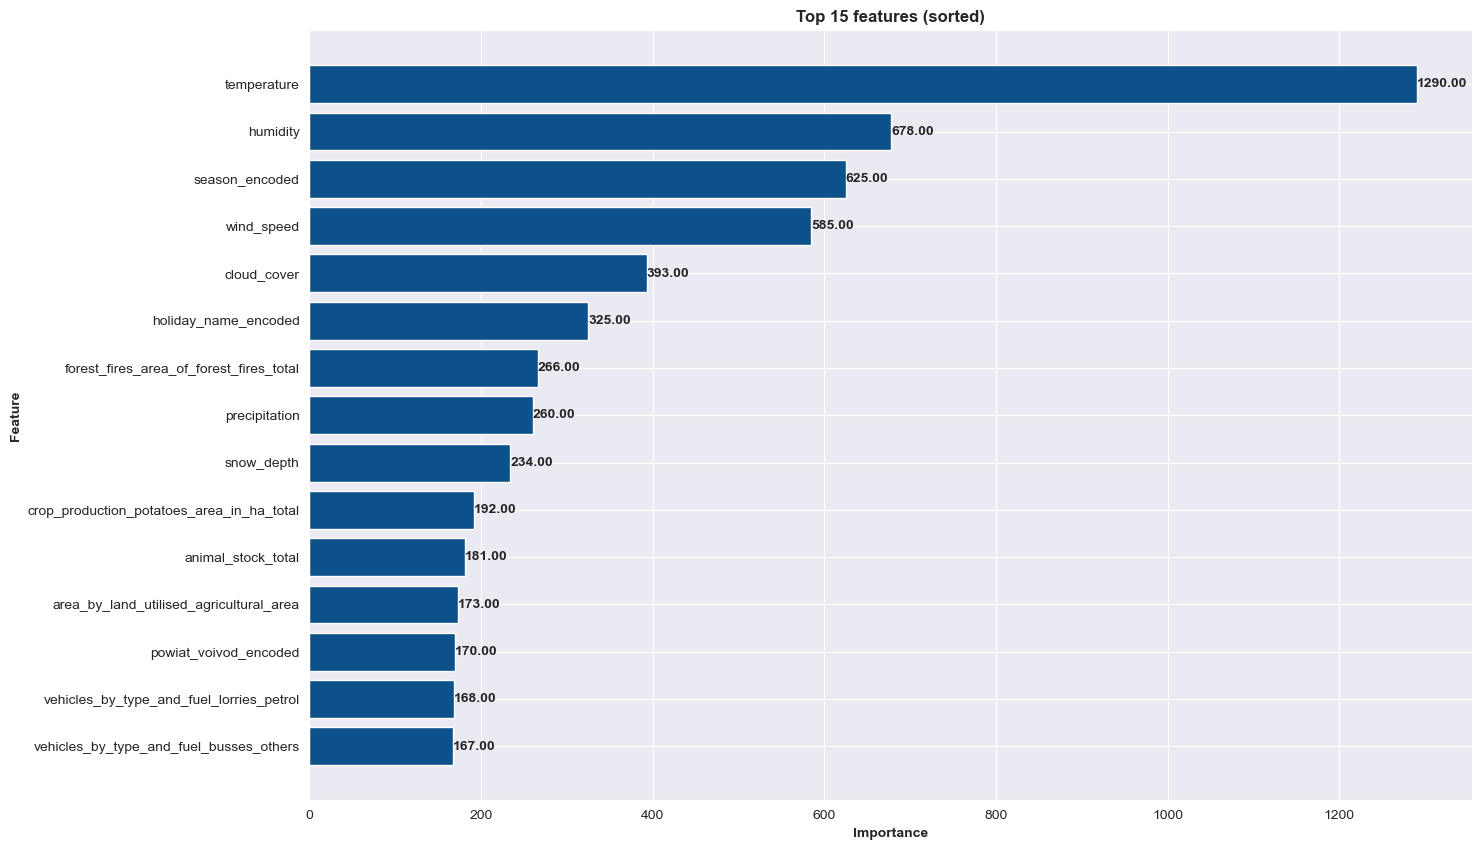

In [38]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_train.columns

# create dataframe of feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Set the style
sns.set_style("darkgrid")

# create horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(feature_importances['feature'][:15], feature_importances['importance'][:15], color='#0d518b')

# add data labels
for index, value in enumerate(feature_importances['importance'][:15]):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', fontweight='bold')

# add chart title and axes labels
plt.title('Top 15 features (sorted)', fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')

# Flip the order of the bars
plt.gca().invert_yaxis()

# display chart
plt.show()

### Key observations:
1. Temperatute by far has contributed the most to our target variable with a score of 1290.
2. Humidity, Windspeed, Season and Cloud cover too play a major in affecting our 'CAQI_level'.

### 15 Least important features:

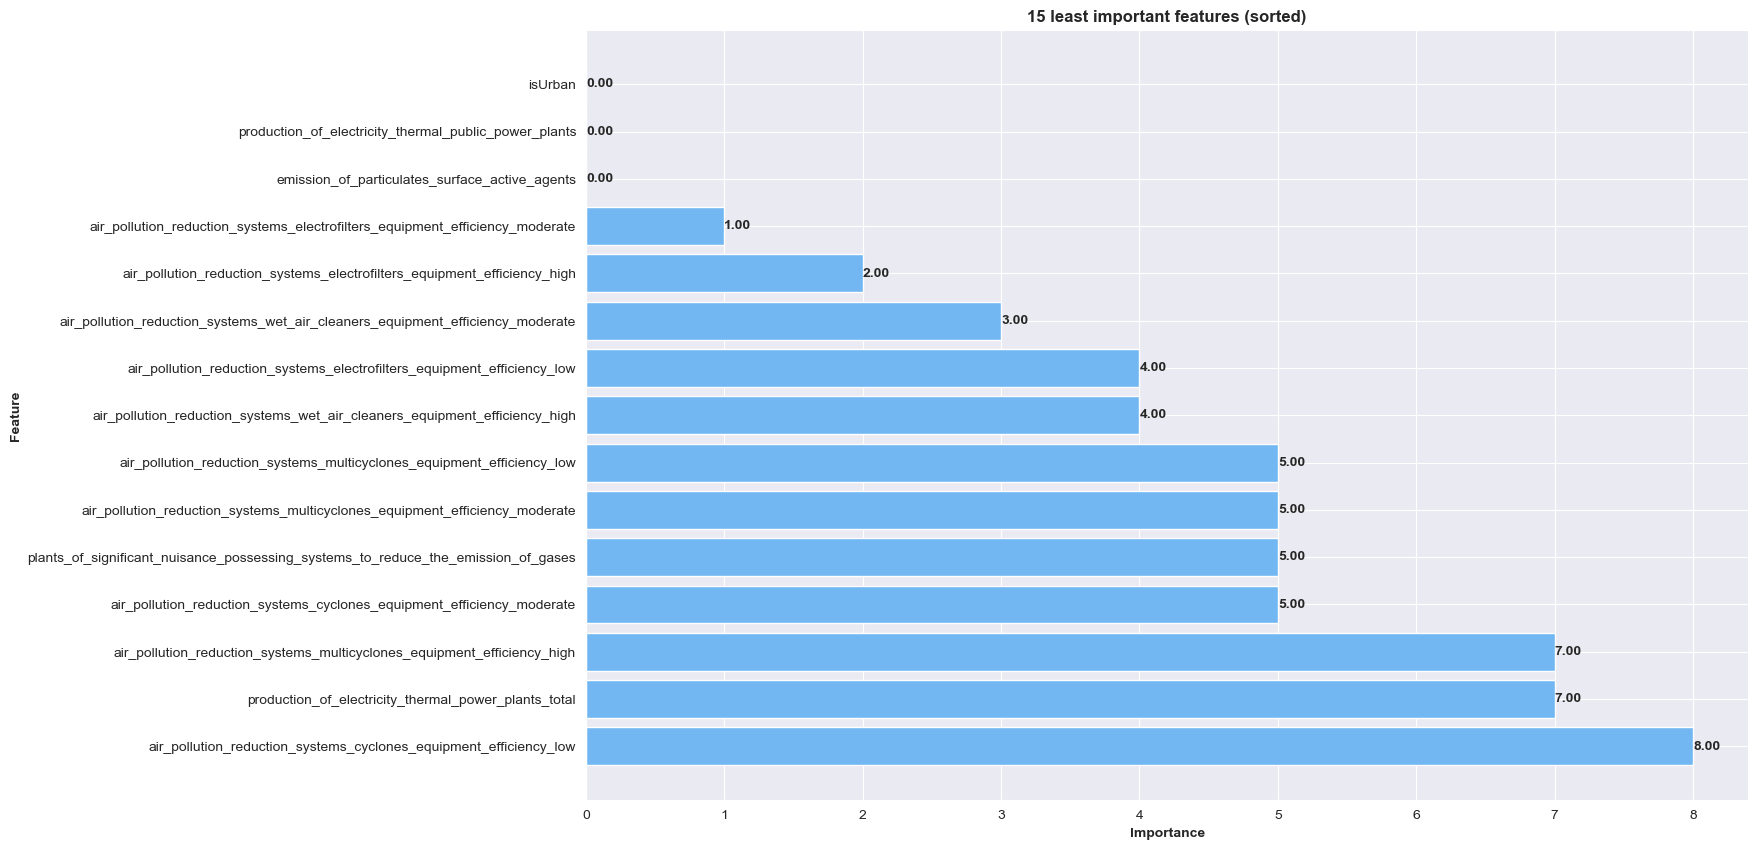

In [39]:
# get feature importances and corresponding feature names
importances = lgbm.feature_importances_
feature_names = X_train.columns

# create dataframe of feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=True)

# Set the style
sns.set_style("darkgrid")

# create horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(feature_importances['feature'][:15], feature_importances['importance'][:15], color='#72b7f2')

# add data labels
for index, value in enumerate(feature_importances['importance'][:15]):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center', fontweight='bold')

# add chart title and axes labels
plt.title('15 least important features (sorted)', fontweight='bold')
plt.xlabel('Importance', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')

# Flip the order of the bars
plt.gca().invert_yaxis()

# display chart
plt.show()

## Key Observations:
- 3 feautures in the data have made **zero contribution** to the target variable.
- Rest of the columns have the least contribution to out target variable.

---

### Cross Validation:

In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#Defining the k-fold cross-validation object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Computing the cross-validation scores
# Used the training set data only for cross validation.
cv_scores = cross_val_score(lgbm, X_train, y_train, cv=kfold, scoring='accuracy')

# Cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.67939261 0.6812201  0.6774156  0.67788078 0.67764819]
Mean CV accuracy: 0.678711456671983


The given **cross-validation scores** indicate the accuracy of the model on each of the subsets used in the cross-validation process.
The **mean CV** score suggests that the model has an average accuracy of about **67.87%** on the data used in the cross-validation.